# Task 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.5.1+cu121
0.20.1+cu121


In [2]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [3]:
angles = np.arange(0, 360, 30)
angle_count = len(angles)

In [4]:
npzfile = np.load("/kaggle/working/latent_space.npz")
encoded_dataset = npzfile['encoded_dataset']
target_encoded = npzfile['target_encoded']

In [5]:
npzfile = np.load("/kaggle/input/rotated-dataset-ml4sci-2025/data.npz")
data_norm = npzfile['data_norm']
target_rotated = npzfile['target_rotated']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(encoded_dataset, target_encoded, test_size=0.2, shuffle=True, random_state=12345)
X_train, X_vali, Y_train, Y_vali = train_test_split(X_train, Y_train, test_size=0.25, shuffle=True, random_state=12345)


print(X_train.shape)
print(Y_train.shape)
print(X_vali.shape)
print(Y_vali.shape)
print(X_test.shape)
print(Y_test.shape)

(8908, 12, 16)
(8908, 12)
(2970, 12, 16)
(2970, 12)
(2970, 12, 16)
(2970, 12)


In [ ]:
X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_vali_pt = torch.Tensor(X_vali).float()
Y_vali_pt = torch.Tensor(Y_vali).int()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).int()


batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt)
vali_dl = DataLoader(dataset_vali, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

dataset_test = TensorDataset(X_test_pt, Y_test_pt)
test_dl = DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=0, drop_last=True)

In [6]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(MLP, self).__init__()

    self.layer1 = nn.Linear(input_dim, hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, output_dim) #output layer

    self.relu = nn.ReLU() # relu function

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x) 
    x = self.layer2(x)
    x = self.relu(x)
    out = self.layer3(x)

    return out

In [ ]:
model = MLP(input_dim=16, output_dim=16, hidden_dim=128)
model = model.to(device)
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,16))
else:
  summary(model, input_size=(1,16))

MLP(
  (layer1): Linear(in_features=16, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=16, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           2,176
              ReLU-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 16]           2,064
Total params: 20,752
Trainable params: 20,752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [ ]:
criterion = nn.MSELoss()

from torch import optim
lr = 0.001
opt = optim.Adam(model.parameters(), lr=lr)

In [ ]:
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"Saving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion
                }, 'best_MLP.pth')

In [ ]:
import time

save_best_model = SaveBestModel() #initialize checkpoint function


epochs = 100
hist_loss = []
hist_vloss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model.train()
    train_loss = 0.
    vali_loss = 0.


    counter = 0
    for xb, _ in train_dl:
        for i in range(angle_count):
            counter += 1
            x_rot = xb[:, i]

            if i == (angle_count - 1):
                y = xb[:, 0]
            else:
                y = xb[:, i+1]

            x_rot =x_rot.to(device)
            y = y.to(device)

            pred = model(x_rot)


            loss = criterion(pred, y)

            train_loss += loss.item()


            # backpropagation
            opt.zero_grad()
            loss.backward()
            opt.step()


    train_loss /= counter


    counter = 0
    model.eval()

    with torch.no_grad():
        for xb, _ in vali_dl:
            for i in range(angle_count):
                counter += 1
                x_rot = xb[:, i]

                if i == (angle_count - 1):
                    y = xb[:, 0]
                else:
                    y = xb[:, i+1]

                x_rot =x_rot.to(device)
                y = y.to(device)

                pred = model(x_rot)


                loss = criterion(pred, y)

                vali_loss += loss.item()



    vali_loss /= counter

    hist_loss.append(train_loss)
    hist_vloss.append(vali_loss)


    save_best_model(vali_loss, epoch, model, opt, criterion)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.5f, train loss: %.5f, vali loss: %.5f"
          % (epoch+1, elapsed_time, train_loss, vali_loss))


Best validation loss: 0.021043755147822092
Saving best model for epoch: 1

epoch: 1, time(s): 1.35482, train loss: 0.03711, vali loss: 0.02104

Best validation loss: 0.015172188224243944
Saving best model for epoch: 2

epoch: 2, time(s): 1.22918, train loss: 0.01832, vali loss: 0.01517

Best validation loss: 0.013000212491665414
Saving best model for epoch: 3

epoch: 3, time(s): 1.23605, train loss: 0.01461, vali loss: 0.01300

Best validation loss: 0.011870326644714003
Saving best model for epoch: 4

epoch: 4, time(s): 1.22977, train loss: 0.01334, vali loss: 0.01187

Best validation loss: 0.010858138241177507
Saving best model for epoch: 5

epoch: 5, time(s): 1.31384, train loss: 0.01235, vali loss: 0.01086
epoch: 6, time(s): 1.26917, train loss: 0.01173, vali loss: 0.01182

Best validation loss: 0.0104784431210989
Saving best model for epoch: 7

epoch: 7, time(s): 1.25280, train loss: 0.01116, vali loss: 0.01048

Best validation loss: 0.01001756008464735
Saving best model for epoch

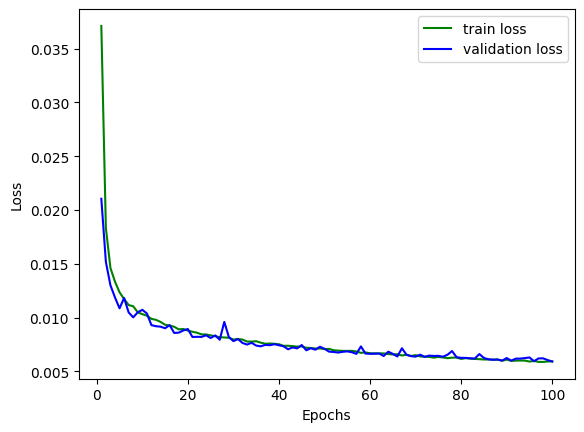

In [ ]:
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [7]:
class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(1, hidden_channels, kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels*2,kernel_size=3, stride=2, padding=1) 

        self.conv3 = nn.Conv2d(hidden_channels*2, hidden_channels*4, kernel_size=3, stride=2, padding=1)

        self.fc1 = nn.Linear(4096, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, int(hidden_channels/2))
        
        self.fc_mu = nn.Linear(in_features=int(hidden_channels/2),
                               out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=int(hidden_channels/2),
                                   out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))

        x = x.view(x.shape[0], -1) #flatten
    
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        
        x_mu = self.fc_mu(x)

        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.conv1 = nn.ConvTranspose2d(hidden_channels, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv2 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels,kernel_size=3, stride=2, padding=1, output_padding=1) 

        self.conv3 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, kernel_size=3, stride=2, padding=1)

        self.fc1 = nn.Linear(hidden_channels, 4096)
        self.fc2 = nn.Linear(int(hidden_channels/2), hidden_channels )

        self.fc = nn.Linear(latent_dim, int(hidden_channels/2))


        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.activation(self.fc(x))
        
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc1(x))
        
        
        x = x.view(x.size(0), self.hidden_channels*4, 4, 4)
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

# Full VAE/AE Model

use_VAE = True #False: AE, True: VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)

        #VAE/AE
        if use_VAE:
          z = self.latent_sample(latent_mu, latent_logvar)
        else:
          z = latent_mu

        x_recon = self.decoder(z)

        # ritorna x ricostruito, mu, e logvar
        return x_recon, latent_mu, latent_logvar

    # sampling function (implementa il reparametrization trick)
    def latent_sample(self, mu, logvar):

        if self.training: #true se si è in training mode
          #campioniamo z(input decoder) da G(mu, sigma)
          sigma = (0.5*logvar).exp()
          z = mu + sigma * torch.randn_like(sigma)
          return z

        else:
          return mu

In [8]:
beta_par = 4.

# VAE loss
def vae_loss(recon_x, x, mu, logvar):

  recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

  if use_VAE:
    # closed form of KL divergence for normal priors: (-1/2 sum (1 + log sigma^2 - mu^2 - sigma^2))
      
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  else:
    kldivergence = 0.0

  return recon_loss + beta_par * kldivergence, recon_loss, beta_par * kldivergence

In [9]:
model = MLP(input_dim=16, output_dim=16, hidden_dim=128)
checkpoint = torch.load("best_MLP.pth", map_location=torch.device("cpu"), weights_only=False )
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


hidden_channels = 64
latent_dim = 16 
encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_vae = VAE(encoder, decoder)
checkpoint = torch.load('./vae_model.pth', map_location=torch.device("cpu"), weights_only=False )
model_vae.load_state_dict(checkpoint['model_state_dict'])
model_vae.to("cpu")
model_vae.eval()

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=4096, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=64, out_features=4096, bias=True)
    (fc2): Linear(in_features=32, out_features=64

In [10]:
test = data_norm[-1]

In [11]:
test_pt = torch.Tensor(test)
test_rec = np.empty((test.shape))

for i in range(angle_count):
    x_rot = test_pt[i]
    x_rot = torch.reshape(x_rot, [1,1,28,28])
    _, mu, _ = model_vae(x_rot)
    murot = model(mu)
    test_rec[i] = decoder(murot).detach().numpy()

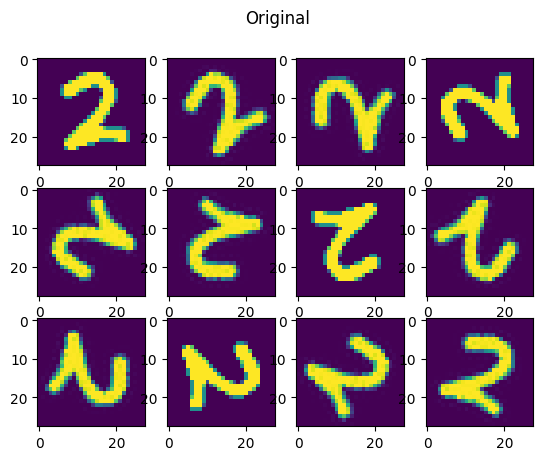

In [12]:
plt.suptitle("Original")
for i in range(len(test)):
    plt.subplot(3,4,i+1)
    plt.imshow(test[i])

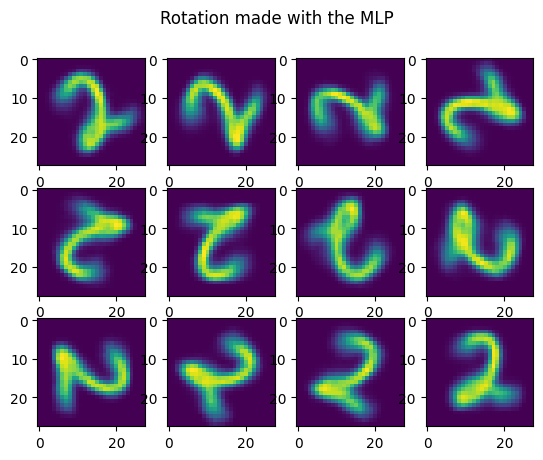

In [13]:
plt.suptitle("Rotation made with the MLP")
for i in range(len(test_rec)):
    plt.subplot(3,4,i+1)
    plt.imshow(test_rec[i])